In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
import tqdm 

# Cargar datos pre-limpiados (output de 0. CleanData)

In [25]:
data = pd.read_csv('./data/rawDataCategoricalAge.csv',encoding='cp1252')
data["id"] = data.index + 1

/home/mauro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Los datos tienen extremos que no representan valores válidos.

In [26]:
data.columns

Index(['idGenero', 'edad_grupos', 'idEstadoCivil', 'idTipoAfiliacion',
       'idNivelAfiliacion', 'fechaActividadA', 'fechaActividadM', 'Analisis',
       'Medicion1_PA_Sistolica', 'Medicion2_PA_Diastolica',
       'Medicion3_Frecuencia_cardiaca', 'Medicion4_Frec_Respiratoria',
       'Medicion5_Temperatura', 'Medicion6_Peso', 'Medicion7_Talla',
       'Medicion8_IMC', 'motivoPaciente', 'enfermedadActual', 'Zona1_Abdomen',
       'Zona2_Cabeza_Cuello', 'Zona3_Cardio_Pulmonar', 'codigoDiagnostico',
       'Plan_Manejo', 'Concepto', 'id'],
      dtype='object')

In [27]:
data = data.drop(['idTipoAfiliacion','idNivelAfiliacion','fechaActividadA','fechaActividadM','Zona1_Abdomen','Plan_Manejo'],axis=1)

In [28]:
data['Medicion5_Temperatura'] = data['Medicion5_Temperatura'].astype(str).str.replace(',','.')
data['Medicion6_Peso'] = data['Medicion6_Peso'].astype(str).str.replace(',','.')
data['Medicion7_Talla'] = data['Medicion7_Talla'].astype(str).str.replace(',','.')

In [29]:
data.columns

Index(['idGenero', 'edad_grupos', 'idEstadoCivil', 'Analisis',
       'Medicion1_PA_Sistolica', 'Medicion2_PA_Diastolica',
       'Medicion3_Frecuencia_cardiaca', 'Medicion4_Frec_Respiratoria',
       'Medicion5_Temperatura', 'Medicion6_Peso', 'Medicion7_Talla',
       'Medicion8_IMC', 'motivoPaciente', 'enfermedadActual',
       'Zona2_Cabeza_Cuello', 'Zona3_Cardio_Pulmonar', 'codigoDiagnostico',
       'Concepto', 'id'],
      dtype='object')

(101116, 19)


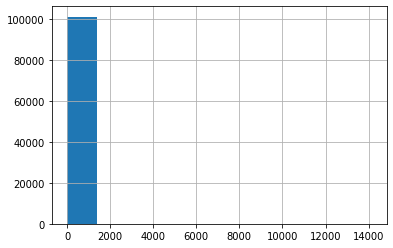

In [30]:
print(data.shape)
data.Medicion1_PA_Sistolica.hist()

# Carguemos los ids filtrados de trifacta y filtremos todo el dataframe

In [33]:
cleanIds = pd.read_csv('./data/Rodrigo.csv')

In [34]:
cleanData = data[data.id.isin(cleanIds.id)]

Los datos ya NO TIIENEN extremos; se pueden usar para clasificar

(96567, 19)


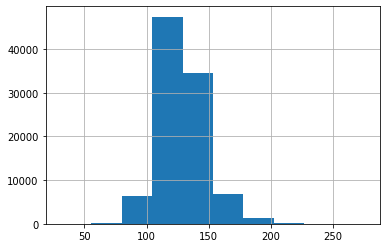

In [35]:
print(cleanData.shape)
cleanData.Medicion1_PA_Sistolica.hist()

# Particion de datos en train y test

In [36]:
def splitTrainTest(dataframe):
    #create output dataframes
    test = pd.DataFrame(columns = dataframe.columns)

    train = pd.DataFrame(columns = dataframe.columns)
    
    for uClass in dataframe.Analisis.unique():
        #get each class 
        classDf = dataframe[dataframe.Analisis == uClass]
        
        # randomly choose 25% of indices 
        ids = [x for x in range(classDf.shape[0])]
        testInd = np.random.choice(ids, int(0.25*len(ids)),replace=False)
        
        trainInd = list(set(ids)-set(testInd))

        #get dataframes
        test = pd.concat([test,classDf.iloc[testInd]])
        
        train = pd.concat([train,classDf.iloc[trainInd]])

    return train,test

In [37]:
train,test = splitTrainTest(cleanData)


Text(0.5, 1.0, 'Train')

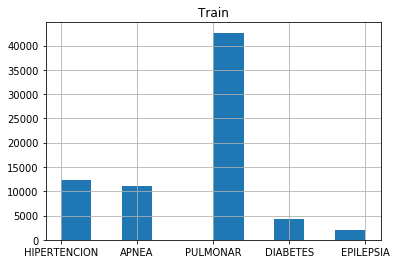

In [38]:
train.Analisis.hist()
plt.title('Train')

Text(0.5, 1.0, 'Test')

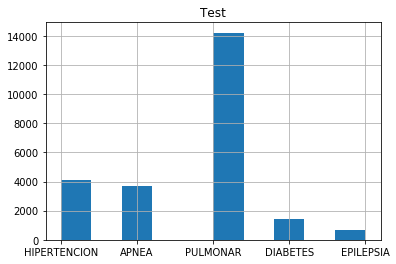

In [39]:
test.Analisis.hist()
plt.title('Test')

In [40]:
train['original'] = True
test['original'] = True

# Balanceo de clases en conjunto de entrenamiento - repitiendo entradas

Enfermedad PULMONAR tiene demasiadas entradas, recotamos en 15k y aumentamos el resto de las clases para que tengan la misma representacion. 15k es un corte arbitrario. Se pueden explorar otros umbrales. 

In [41]:
 def oversample(dataframe, oversampleThreshold):
        
    ans = pd.DataFrame(columns=dataframe.columns)
    
    for uClass in tqdm.tqdm(dataframe.Analisis.unique()):
        #get each class 
        classDf = dataframe[dataframe.Analisis == uClass]
        ids = classDf.id
        
        if classDf.shape[0]< oversampleThreshold:
            
            while(classDf.shape[0]<oversampleThreshold):
                missing = oversampleThreshold-classDf.shape[0]
                if missing>=classDf[classDf.original==True].shape[0]:
                    sample = classDf[classDf.original==True].copy()
                    sample['original']= False
                    classDf = pd.concat([classDf,sample])
                else:
                    sample = classDf[classDf.original==True].sample(n=int(missing), random_state=1,replace=False)
                    sample['original']= False
                    classDf = pd.concat([classDf,sample])
                    
            
        elif classDf.shape[0]> oversampleThreshold:
            newIds = np.random.choice(ids, int(oversampleThreshold),replace=False)
            classDf = classDf[classDf.id.isin(newIds)]

        #get dataframes
        ans = pd.concat([ans,classDf])
        

    return ans

In [42]:
oversampledTrainData = oversample(train, 15e3)

100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


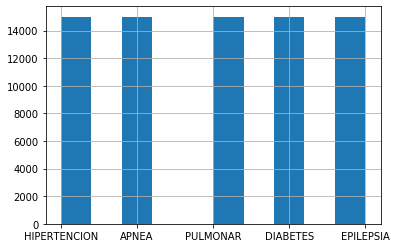

In [43]:
oversampledTrainData.Analisis.hist()

In [44]:
train['dataset'] = 'train'
test['dataset'] = 'test'
allData = pd.concat([train,test])

In [45]:
allData

,idGenero,edad_grupos,idEstadoCivil,Analisis,Medicion1_PA_Sistolica,Medicion2_PA_Diastolica,Medicion3_Frecuencia_cardiaca,Medicion4_Frec_Respiratoria,Medicion5_Temperatura,Medicion6_Peso,...,Medicion8_IMC,motivoPaciente,enfermedadActual,Zona2_Cabeza_Cuello,Zona3_Cardio_Pulmonar,codigoDiagnostico,Concepto,id,original,dataset
0,1,1-67,9,HIPERTENCION,138,82,64,19,36.3,88,...,28.73,CONTROL,PACIENTE DE 60 AÑOS DE EDAD CON DIAGNOSTICOS ...,Sin alteraciones.,RSCS RIMTICOS SIN SOPLOS RSRS MURMULLO EVSICUL...,I10X,PACIENTE DE 60 AÑOS DE EDAD CON DIAGNOSTICOS H...,1,True,train
1,2,78-84,1,HIPERTENCION,187,64,73,17,36.2,53,...,30.42,""" TENEMOS EL CONTROL """,PACIENTE DE 76 AÑOS CON DIAGNOSTICO: 1. HIP...,Sin alteraciones.,RSRS SIN AGREGADOS RSCS RITMICOS SIN SOPLOS,I10X,PACIENTE EN PROGRAMA CRONICO; CURSA CON HTA EN...,2,True,train
8,2,1-67,3,HIPERTENCION,118,75,90,19,36.2,57,...,26.02,CONTROL CRÓNICOS CAPITAL SALUD NATURAL LA CAP...,PACIENTE FEMENINA DE 54 AÑOS CON DIAGNÓSTICOS ...,SIN CIANOSIS,RUIDOS CARDIOVASCULAR RUIDOS RESPIRATORIOS CO...,I10X,PACIENTE FEMENINA CON DIAGNÓSTICOS ANOTADOS S...,9,True,train
9,2,>84,1,HIPERTENCION,158,59,58,15,36,56,...,24.89,CONTROL PROGRAMA CRONICOS,PACIENTE DE 84 AÑOS CON DIAGNOSTICOS DE: 1. E...,NO INGURGITACION YUGULAR.,RSCS RITMICOS SIN SOPLOS. RSRS MV CONSERVADOS ...,I10X,PACIENTE ADULTA MAYOR CON DIAGNOSTICOS ANOTAD...,10,True,train
11,2,1-67,9,HIPERTENCION,112,76,95,20,36.6,79,...,34.19,CONTROL,PACIENTE DE 42 AÑOS DE EDAD CON DIAGNOSTICO DE...,Sin alteraciones.,RSCS RITMICOS SIN SOPLOS RSRS MURMULLO EVSICUL...,I10X,PACIENTE DE 42 AÑOS DE EDAD CON DIAGNOSTICO DE...,12,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69557,1,1-67,9,EPILEPSIA,110,66,78,17,36.0,87.0,...,26.85,REFORMULACION NEUROLOGIA,PACIENTE DE 61 AÑOS CON DIAGNOSTICOS DE: 1. ...,CUELLO CORTO Y ANCHO MNUCOAO ORAL HUMEDA,RSCS RITMICO SIN SOPLOS RSRS SIN AGREAGDOS,G403,PACIENTE DE 61 AÑOS CON DIAGNOSTICO DE EPILEP...,69558,True,test
86880,2,1-67,6,EPILEPSIA,110,70,88,18,36.5,35.0,...,16.20,"""INICIAR HISTORIA CLINICA""",PACIENTE D E11 AÑOS DE EDAD EN COMPAÑIA DE SU ...,NORMOCEFALICO ESCLERAS ANICTERICAS CONJUNTIV...,TORAX NORMOEXPANSIBLE RUIDOS CARDIACOS RITMIC...,G409,PACIENTE DE 11 AÑOS DE EDAD CON ANTECEDENTE DE...,86881,True,test
83968,2,1-67,1,EPILEPSIA,120,70,74,20,37.0,57.0,...,18.61,REFORMULACION,PACIENTE FEMENINA DE 45 AÑOS CON DX: 1. EPIL...,I,I,G402,PACIENTE CON EPILEPSIAREFRACTARIA EN CONTROLES...,83969,True,test
82835,2,1-67,9,EPILEPSIA,110,60,68,20,37.0,61.0,...,25.72,REFORMULACION,PACIENTE FEMENINA DE 38 AÑOS CON DX DE : 1....,I,I,G409,PACIENTE CON EPILEPSIA FOCAL REFRACTARIA + ESC...,82836,True,test


In [46]:
allData.to_csv('./data/preClasificacion.csv',encoding='utf8')